# ME 401 Project 1 : Hybrid Energy Systems

You have been tasked with designing a hybrid energy system optimized for the electification of a major US shipping port's ground support infrastructure. The design must also meet the energy needs of a nearby housing development.

# Part 1: Data Analysis

The first part of the project will involve data import, interpretation, and optimization.

## Step 1: Source Data

Each team has been assigned a port to analyze. Step one is to gather the requisite data for the creation of a basic demand curve. The daily baseload data is provided, 'port_demand_raw.csv'. Each team is responsible for gathering three data sets from the 'demand.ninja' website. 

[ https://www.renewables.ninja/ ] 

solar photovoltaic, wind, and heating & cooling demand will all be used. Save the outputs and upload them to your notebook's input. The default settings can all be used. Select an area near the port of interest, run the simulation and save the hourly output as a '.csv' file. 

Upload those files to this notebook 'Input' found in the right sidebar.

#### Jupyter Notebook / Python Note:
Each python script begins with a series of imports. It is not necessary to import items to run python but it does allow for the incorporation of different libraries and files.

Here we are importing the linear algebra library 'numpy' and assigning it the name 'np' to provided a convenient reference for use within the code. Numpy is a 'library', an open source software designed for python which anyone can download and use for free.

Additionally we will import the program files for our optimization.

To run a cell, select the triangular 'run' button next to the selected cell or at the top of the notebook window.

In [1]:
# The kaggle environment comes with many preinstalled libraries
# Libraries are referenced with the 'import' command

import numpy as np # linear algebra library
import pandas as pd # data analysis library
from scipy.optimize import minimize #optimization library
import sys # allow python to access internal folders

# tell python where to look for the program files:
sys.path.insert(1, '/kaggle/input/py-scripts')
# Import the provided program files 
import data_formatter as idf
import supply_optimizer as opt
import bess_optimizer as heo

# print statements are an easy way to verify that a cell has run
print("Import cell Success!")

Import cell Success!


## Step 2: Input Data

The generated data sets will have to uploaded to the notebooks 'Input' folder. Then the file paths can added to the code below (each .csv file has a button to copy the filepath).

Once the variables below are linked to the uploaded files, the optimization process is ready to begin!

In [2]:
wind = '/kaggle/input/dataset/NOLA_wind.csv'
solar = '/kaggle/input/dataset/NOLA_solar.csv'
heat = '/kaggle/input/dataset/NOLA_heat.csv'
port_location = 'New Orleans'
port_file = '/kaggle/input/port-data-set/Port_demand_raw.csv'
print('File references created')

File references created


## Step 3: Format Data

The data formatter functionality is called to take the raw data sets and create data frames which can be easily accessed and used to create arrays and organize the pertinent information. The hourly data is averaged here over 12 hour increments to create two data points per day instead of 24. This smoothes the trend lines and makes the analysis easier to visualize at the cost of model fidelity.

Upon successful formatting, the function will output the degree to which the files had to be altered to match lengths. [expected alteration ~ 15 values ]

In [3]:
#create dataFormatter object
data = idf.DataFormatter()
#upload and format port electrical demand
data.gather_port_demand(port_file,port_location)
#upload and format heating / cooling demand
data.gather_heat_demand(heat)
#compile both port and heating / cooling demand
data.build_demand()
#upload and format PV generation data
data.gather_solar(solar)
#upload and format wind generation data
data.gather_wind(wind)
# ensure all array lengths are equal after formatting
data.check_array_length()

array mismatch demand / generation
dropped 15 values from generation arrays



## Step 4: Optimize Renewable Generation

#### Optimization of wind and solar array sizes
Now the formatted arrays are used to optimize wind and solar installations based on the production capacity data. This optimization is accomplished with scipy.minimize using an 'SLSQP' or sequential least squares programming algorithm. 

note: The 'make_arrays' function has an implicit parameter 'target_generation = 0.7'. This tells the optimizer the desired percentage of demand to be met with renewables. 

scipy documentation:
https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html

In [4]:
#Create a production optimization object
optimizer = opt.SolarWindOptimizer()
#prepare arrays from the formatted data object created above
optimizer.make_arrays(data.wind, data.solar, data.demand)
#use scipy (an open source library) to optimize the portfolio
optimizer.optimize()

Optimization successful!
Optimal PV capacity: 1148.49 kW
Optimal Wind capacity: 2144.51 kW
PV/Wind ratio: 0.54
Average renewable generation: 796.89 kW
Target generation: 796.89 kW
Root mean square error: 1028.18 kW


#### Capital Expenditure Analysis of Renewable Capacity:
Once the PV and wind arrays have been optimized to meet the desired goals, the daily generation capacity array is scaled by the optimized value.

Based on U.S. Energy Information Administration data, the construction cost per kW is assumed to be \\$1,451 for wind and \\$1,588 for solar.

www.eia.gov/todayinenergy/detail.php?id=63485

In [5]:
data.solar = data.solar * optimizer.opt_solar_
data.wind = data.wind * optimizer.opt_wind_
print("Wind and Solar capacities updated")
print(f"Wind capacity: {(optimizer.opt_wind_*10**-3).round(2)} MW")
print(f"Solar capacity: {(optimizer.opt_solar_*10**-3).round(2)} MW")
wind_capex = (optimizer.opt_wind_ * 1451).round(2)
solar_capex = (optimizer.opt_solar_ * 1588).round(2)
print(f"Construction cost Wind: ${wind_capex:,}") 
print(f"Construction cost Solar: ${solar_capex:,}")


Wind and Solar capacities updated
Wind capacity: 2.14 MW
Solar capacity: 1.15 MW
Construction cost Wind: $3,111,688.45
Construction cost Solar: $1,823,805.59


## Step 5: Visualize Data Patterns

The optimized generation data can now be used to simulate the annual supply curve. The output of this initial analysis forms the basis of a means to optimize a battery energy storage system (BESS).

The basic trends are visualized below.

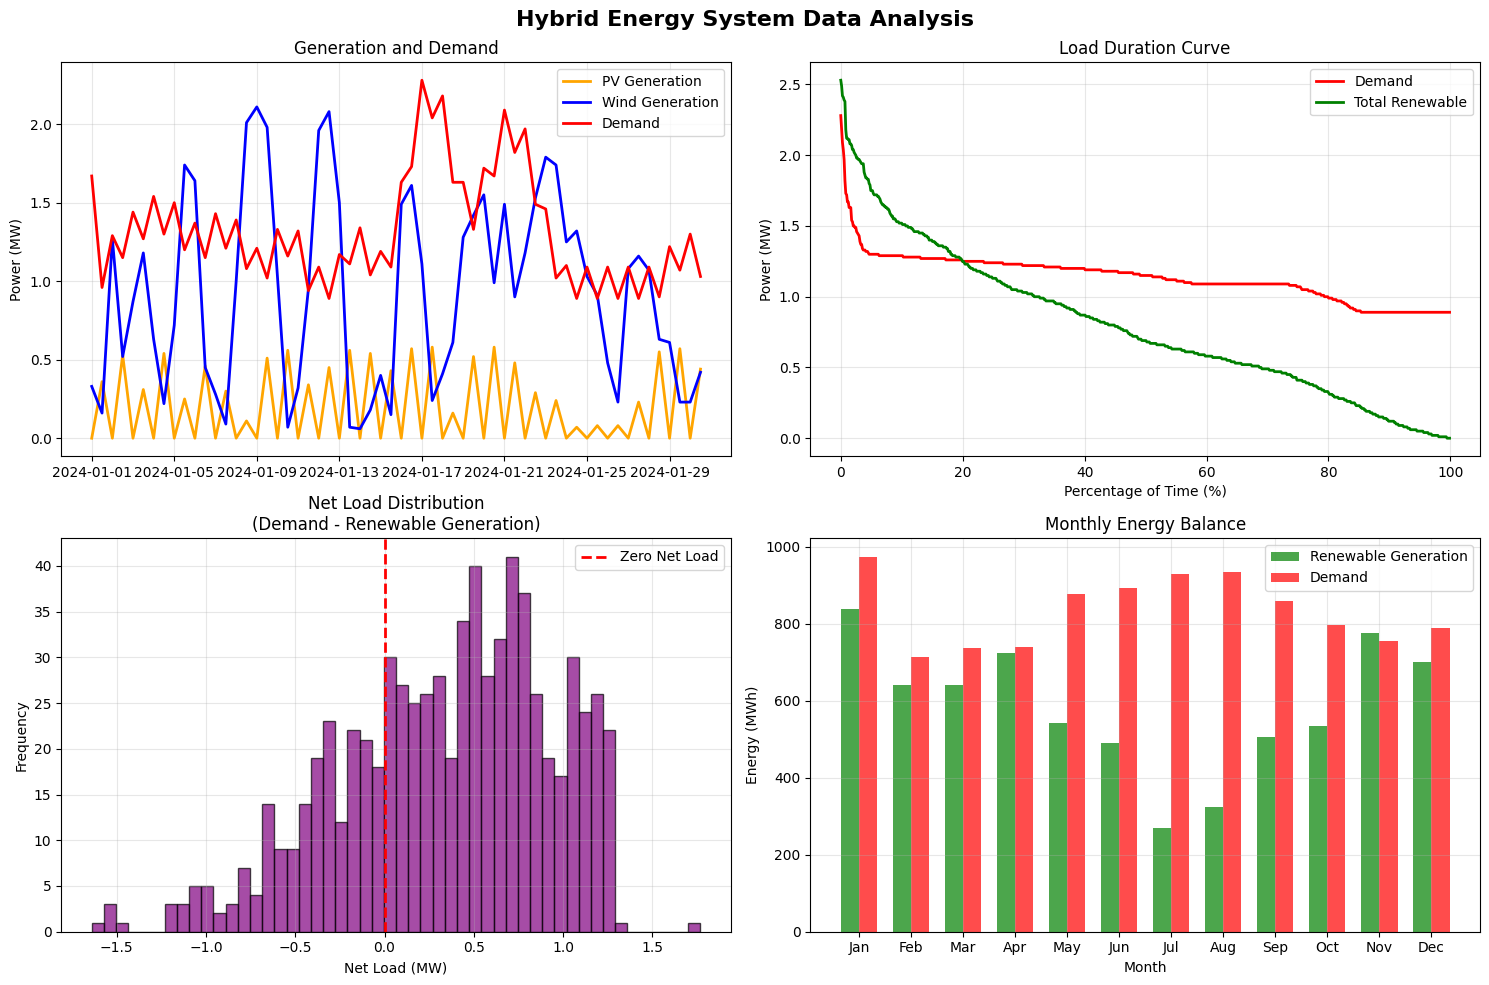


SYSTEM DATA ANALYSIS SUMMARY
Peak Demand: 2.3 MW
Average Demand: 1.1 MW
Peak Renewable Generation: 2.5 MW
Average Renewable Generation: 0.8 MW
Maximum Net Load: 1.8 MW
Minimum Net Load: -1.6 MW
Periods with Excess Renewable: 198 / 731 intervals
Renewable Penetration: 69.9%


In [6]:
#create 'bess' optimizer object
system = heo.HybridEnergyOptimizer()
#populate optimizer time series with energy data
system.time_series = data.produce_avg_data_frame()
system.visualize_data_patterns()

## Step 6: Optimize Power Generation & Energy Storage

Now that the probable production and demand curves are established, it is possible to use this data along with an objective function to optimize the size of the BESS (Battery Energy Storage System) and Rankine Cycle output simultaneously.

In [7]:
#results = system.simulate_bess_operation()
system.optimize_bess_capacity()
print("Optimization Process Complete")


BATTERY ENERGY STORAGE SYSTEM OPTIMIZATION
Optimizing both BESS capacity (MWh) and Rankine power (MW)
Optimal BESS capacity: 15.5 MWh
Optimal Rankine power: 1.3 MW
Target reliability: 95.0%
Achieved reliability: 100.0%

Optimization Process Complete


## Step 7: Visualize Results

The optimizer object can then display its findings in an organized manner.
It is worth noting that all outputs and design parameters can be tuned to explore different design spaces. The outputs can be easily formatted to create a series of metrics that can be included in a technical report and provide an accessible summary of the entire optimization process. 

~~ NOTE:
Visualizations will be saved in the 'Output' tab on the right as .png files for inclusion in the final report. ~~


OPTIMIZATION RESULTS & PERFORMANCE ANALYSIS

OPTIMAL BESS CONFIGURATION:
  Battery Power Rating: 4.0 MW (fixed)
  Optimal Energy Capacity: 15.5 MWh

SYSTEM RELIABILITY PERFORMANCE:
  Achieved Reliability: 100.00%
  Target Reliability: 95.0%
  Total Energy Not Served: 0.5 MWh
  Number of Loss-of-Load Events: 1
  Average Event Duration: 1.0 intervals
  Maximum Event Duration: 1 intervals

BESS PERFORMANCE INDICATORS:
  Capacity Factor: 9.1%
  Annual Equivalent Cycles: 238
  Throughput Utilization: 10.0%
  Actual Round-trip Efficiency: 83.2%
  Energy Discharged (Annual): 1591 MWh
  Energy Charged (Annual): 1912 MWh

ECONOMIC ANALYSIS:
  BESS Capital Cost: $2,326,120
  Annual Fuel Cost (Rankine): $177,218
  Levelized Cost per MWh: $148.96/MWh

BACKUP POWER UTILIZATION:
  Total Rankine Energy: 2215 MWh
  Rankine Capacity Factor: 9.0%


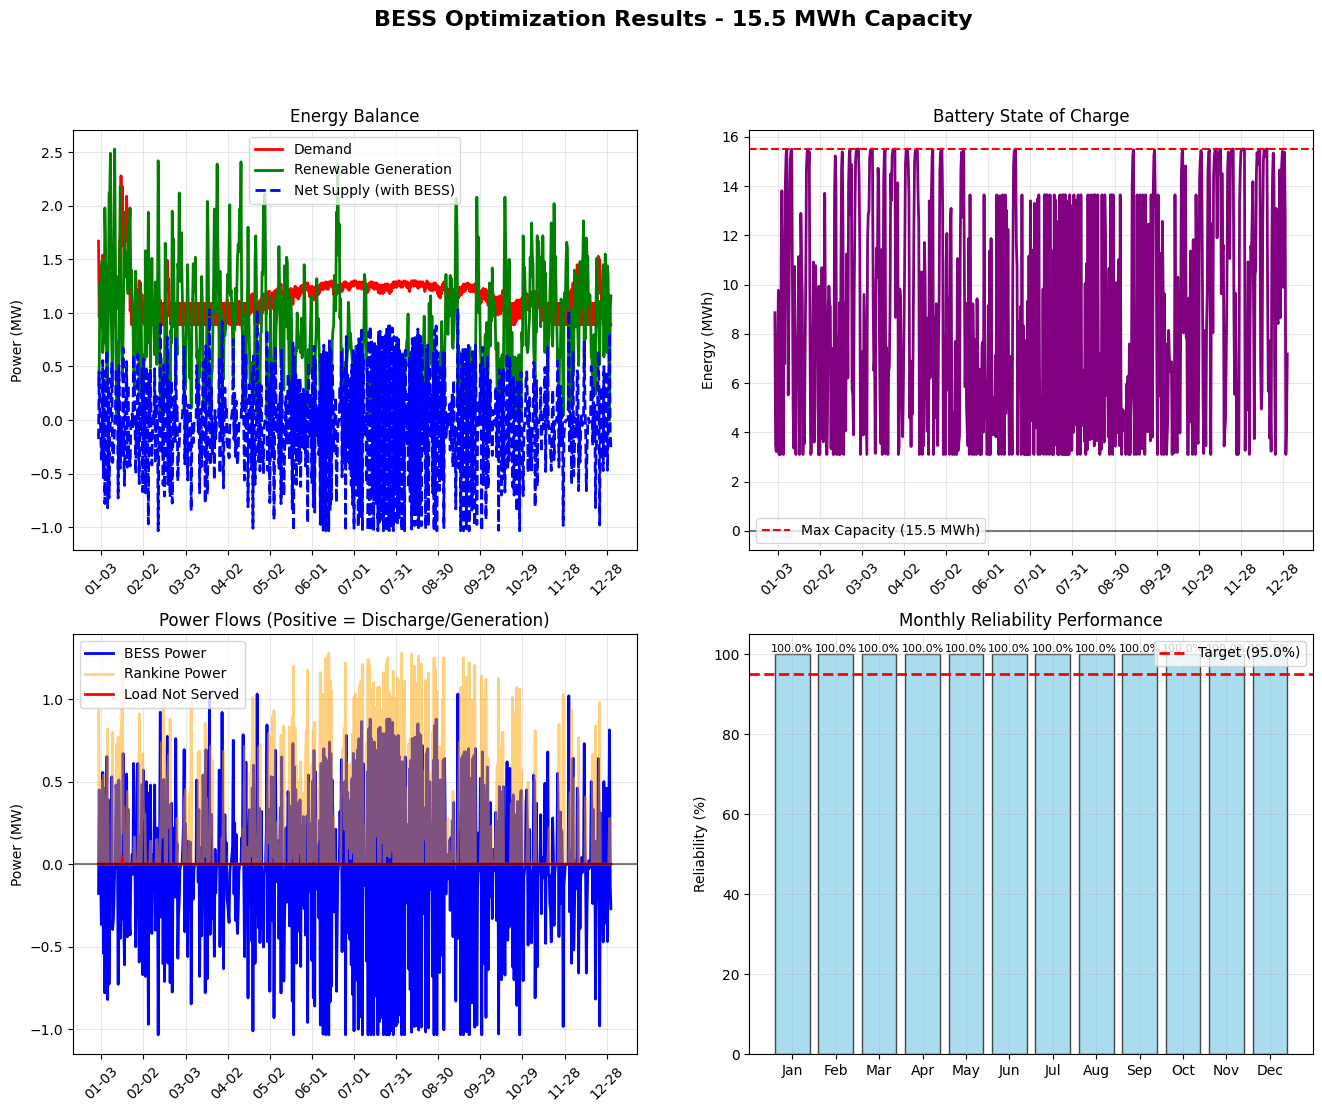

In [8]:
system.display_results()

# Part 2: Simulation of Rankine Cycle

The next part of the project will be carried out in COMSOL, a Multiphysics modeling software.

Each group will need to model the boiler in their Rankine Cycle. Refer to the class repository for more information and .mph files.